In [1]:
import os
import re
import json
import pickle
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import sentencepiece as spm

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from datetime import datetime
from tqdm.notebook import tqdm
from wordcloud import WordCloud

In [2]:
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

# 랜덤 시드 수동 설정
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

# 1. KroQuAD dataset and BERT model load

> KorQuAD(The Korean Question Answering Dataset, 한국어 질의응답 데이터셋)는 딥러닝 기반 QA(질의응답), 한국어 독해 능력을 측정하는 가장 중요한 태스크로 사용된다.<br>
> KorQuAD 데이터 셋과, 데이터 셋을 활요하기 위한 BERT QnA 모델을 메모리에 적재후 데이터를 확인하는 작업을 진행한다.

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/bert_qna/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_qna/models'

> KorQuAD 데이터 셋의 내용을 확인하기 위한 사용자 정의 함수를 구현한다.

In [5]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

> KorQuAD 데이터 셋의 훈련용 데이터를 확인하기 위해, 첫번째 내용을 출력하여 확인한다.

In [6]:
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


> KorQuAD 데이터 셋의 검증용 데이터를 확인하기 위해, 첫번째 내용을 출력하여 확인한다.

In [7]:
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


> 불러온 데이터를 확인한 결과 여러 데이터 중, 모델에 사용할 주요한 정보는 아래와 같다.<br><br>
> Text(정답) - 퀴즈의 정답 데이터이다.<br>
> Question(질문) - 퀴즈의 질문 데이터이다.<br>
> Context(지문) - 퀴즈 질문에 대한 상세설명 데이터이다.<br>
> Title - 퀴즈의 주제

# 2. Data processing

> 모델 구성을 위해 데이터를 목적에 맞게 가공할 수 있도록, 데이터의 형태를 분석하는 과정을 진행한다.

## 2.1 sentence data preprocessing

> 컴퓨터는 띄어쓰기 또한 하나의 데이터로 인식하여 메모리 공간을 할당받는다<br>
> 그러나, 우리가 사용할 문장에서 무의미한 띄어쓰기는 의미 없는 정보이다.<br>
> 이에 중복 띄어쓰기를 제거하는 데이터 전처리 작업을 진행하기 위한 함수를 구현한다.<br>
> 아래 사용자 정의 함수는 활용하여 띄어쓰기 단위로 token을 정리한 후, word token 영역별로 고유 숫자(어절)를 부여하는 작업을 진행한다.

In [8]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [9]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

## 2.2 Tokenize by Vocab

> 한국어는 하나의 단어를 활용하여 수많은 단어를 생성할 수 있다. (ex. 하다 | 하였다, 하였으니, 했으니, 했으나, 하였으나 etc..)<br>
> 이는 좋은 장점이나, 이를 컴퓨터가 처리할 수 있도록 단어사전을 만들기에는 너무 많은 토큰이 필요하다.<br>
> 이에, 적절한 Subword 분절 규칙을 학습하거나, 혹은 자주 사용되는 구문을 하나의 단어로 묶어내는 등 통계적인 방법을 사용하는<br>
> Subword Segmentation기법을 활용하여 단어사전을 구축하는 함수를 구현한다.

In [10]:
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

## 2.3 Improve span

> KorQuAD 데이터셋은 질문(question)과 지문(context)을 주고, 지문 영역에서 정답(answer)을 찾도록 구성되어 있다.<br>
> 때문에, 정답에 해당하는 지문 영역을 정확히 찾아내는 것이 핵심이다.<br>
> 이에, KorQuAD 데이터셋에서 context, question, answer을 추출하는 공정을 진행한다.

> KorQuAD 데이터셋에서 목적에 맞는 데이터를 정확히 추출하는 함수를 구현하기 이전에, 임의의 데이터를 추출하는 실험을 진행한다.<br>
> KorQuAD 데이터셋의 훈련용 데이터 중 첫번째 데이터를 추출해보았다.

In [11]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


> KorQuAD 데이터셋은 질문과 지문을 주고, 지문 영역에서 정답을 찾도록 구성되어 있다.<br>
> 이에, context에서 answer의 위치를 토큰화하여, 정답에 해당하는 지문 정역을 탐색하는 전처리를 진행한다.

In [12]:
word_tokens, char_to_word = _tokenize_whitespace(context)
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_start = word_to_token[word_start]

if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
    
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['▁교향곡', '을'])

> 위 실험으로, 데이터 트리 구조에 맞게 데이터를 추출하는 사용자 정의 함수를 구현한다.

In [13]:
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

> 훈련용 데이터의 첫번째 데이터로 사용자 정의 함수 성능을 평가한 결과, 올바르게 정답에 해당하는 지문을 추출하였다.

In [14]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['▁교향곡']

## 2.4 Separate KorQuAD dataset.

> KorQuAD dataset으로부터 모델 학습에 사용할 train 데이터셋, dev 데이터셋을 분리하여 저장하는 사용자 정의 함수를 구현한다.

In [15]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

> 위 사용자 정의 함수를 활용하여 훈련용과 검증용 데이터 셋을 file로 생성한다.

In [16]:
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

> 생성한 훈련용 데이터셋이 잘 생성되었는지 확안하는 과정을 진행한다.

In [17]:
def print_file(filename, count=10):
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(f"{data_dir}/korquad_train.json")

{"qa_id": "6566495-0-0", "title": "파우스트_서곡", "question": ["▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "를", "▁읽고", "▁무엇을", "▁쓰고", "자", "▁", "했", "는", "가", "?"], "context": ["▁1839", "년", "▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "을", "▁처음", "▁읽고", "▁그", "▁내용에", "▁마음이", "▁끌려", "▁이를", "▁소재로", "▁해서", "▁하나의", "▁교향곡", "을", "▁쓰", "려는", "▁뜻을", "▁갖는다", ".", "▁이", "▁시기", "▁바그너", "는", "▁1838", "년에", "▁빛", "▁독", "촉", "으로", "▁산", "전", "수", "전을", "▁다", "▁", "걲", "은", "▁상황이", "라", "▁좌절", "과", "▁실망", "에", "▁가득", "했으며", "▁메", "피스", "토", "펠", "레스", "를", "▁만나는", "▁", "파우스트", "의", "▁심", "경에", "▁공감", "했다고", "▁한다", ".", "▁또한", "▁파리에서", "▁아브", "네", "크의", "▁지휘", "로", "▁파리", "▁음악원", "▁관현악단", "이", "▁연주하는", "▁베토벤", "의", "▁교향곡", "▁9", "번을", "▁듣고", "▁깊은", "▁감", "명을", "▁받았는데", ",", "▁이것이", "▁이듬해", "▁1", "월에", "▁", "파우스트", "의", "▁서", "곡으로", "▁쓰여진", "▁이", "▁작품에", "▁조금", "이라도", "▁영향을", "▁끼", "쳤", "으리라", "는", "▁것은", "▁의심", "할", "▁여지가", "▁없다", ".", "▁여기", "의", "▁라", "단", "조", "▁조성", "의", "▁경우에도", "▁그의", "▁전기", "에", "▁적혀", "▁있는", 

## 2.5 Data analysis

> 위 2.4의 과정으로 얻은 데이터의 문제점이 있는지 분석하는 과정을 진행한다.

### 2.5.1 Question

> Question 데이터의 구성 형태와 이상치등의 문제가 있을수 있는 값을 탐색하는 작업을 진행한다.

In [18]:
questions = []
contexts = []
token_starts = []

with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])

In [19]:
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[16, 14, 16, 12, 16, 13, 10, 13, 16, 18]

> 임의로 10개를 추출하여 문장길이를 확인했을때, 10,12,13,14, 16 등의 수치로 보아 10~20이 평균이지 않을까 생각한다.<br>
> 좀 더 자세한 확인을 위해 Question의 모든 데이터를 아래 그림으로 출력하여 확인한다.

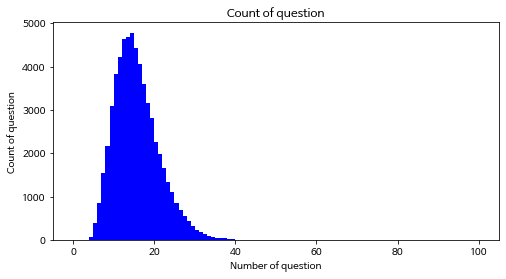

In [20]:
plt.figure(figsize=(8, 4))
plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')
plt.title('Count of question')
plt.xlabel('Number of question')
plt.ylabel('Count of question')
plt.show()

> 위 그림으로,대부분의 값이 10~20에 분포되어있음을 확인 할 수 있다.<br>
> 이를 명확하게 수치로 표현하면 아래와 같다.

In [21]:

print(f"question 길이 최대:    {np.max(train_question_counts):4d}")
print(f"question 길이 최소:    {np.min(train_question_counts):4d}")
print(f"question 길이 평균:    {np.mean(train_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(train_question_counts):7.2f}")

percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5

print(f"question 25/100분위:  {percentile25:7.2f}")
print(f"question 50/100분위:  {percentile50:7.2f}")
print(f"question 75/100분위:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")

question 길이 최대:      58
question 길이 최소:       3
question 길이 평균:      15.25
question 길이 표준편차:    5.50
question 25/100분위:    11.00
question 50/100분위:    14.00
question 75/100분위:    18.00
question IQR:           7.00
question MAX/100분위:   28.50


> 질문 문장의 경우 최대 길이는 58, 최소는 3, 평균 15이며, 편차는 +- 5임을 확인할 수 있다.

### 2.5.2 Context

> Context 데이터의 구성 형태와 이상치등의 문제가 있을수 있는 값을 탐색하는 작업을 진행한다.

In [22]:
train_context_counts = [len(context) for context in contexts]
train_context_counts[:10]

[278, 278, 278, 278, 278, 278, 278, 278, 209, 209]

> 임의로 10개를 추출하여 문장길이를 확인했을때, 278, 209의 수치로 보아 200~300이 평균이지 않을까 생각한다.<br>
> 좀 더 자세한 확인을 위해 Context의 모든 데이터를 아래 그림으로 출력하여 확인한다.

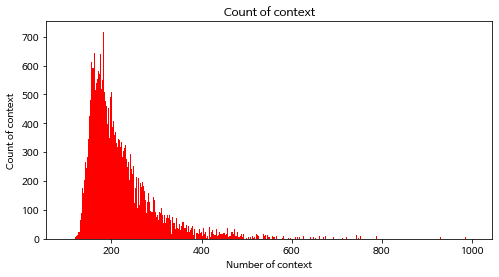

In [23]:
plt.figure(figsize=(8, 4))
plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')

plt.title('Count of context')
plt.xlabel('Number of context')
plt.ylabel('Count of context')
plt.show()

> 위 그림으로,대부분의 값이 150~250에 분포되어있음을 확인 할 수 있다.<br>
> 이를 명확하게 수치로 표현하면 아래와 같다.

In [24]:
print(f"context 길이 최대:    {np.max(train_context_counts):4d}")
print(f"context 길이 최소:    {np.min(train_context_counts):4d}")
print(f"context 길이 평균:    {np.mean(train_context_counts):7.2f}")
print(f"context 길이 표준편차: {np.std(train_context_counts):7.2f}")

percentile25 = np.percentile(train_context_counts, 25)
percentile50 = np.percentile(train_context_counts, 50)
percentile75 = np.percentile(train_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5

print(f"context 25/100분위:  {percentile25:7.2f}")
print(f"context 50/100분위:  {percentile50:7.2f}")
print(f"context 75/100분위:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100분위: {percentileMAX:7.2f}")

context 길이 최대:    4816
context 길이 최소:     108
context 길이 평균:     222.84
context 길이 표준편차:   97.68
context 25/100분위:   169.00
context 50/100분위:   199.00
context 75/100분위:   248.00
context IQR:          79.00
context MAX/100분위:  366.50


> 지문의 경우 최대 길이는 4816, 최소는 108, 평균 222이며, 편차는 +- 97임을 확인할 수 있다.

### 2.5.3 Answer

> Answer 데이터의 구성 형태와 이상치등의 문제가 있을수 있는 값을 탐색하는 작업을 진행한다.

In [25]:
train_answer_starts = token_starts
train_answer_starts[:10]

[19, 168, 80, 6, 143, 0, 165, 216, 164, 7]

> 임의로 10개를 추출하여 문장길이를 확인했을때, 0,19,80,160,216 등의 수치의 분포가 넓어 평균을 가늠하기 힘들다.<br>
> 좀 더 자세한 확인을 위해 Answer의 모든 데이터를 아래 그림으로 출력하여 확인한다.

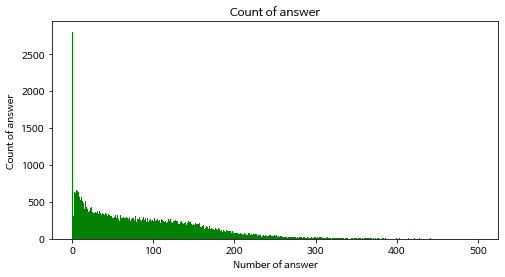

In [26]:
plt.figure(figsize=(8, 4))
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')

plt.title('Count of answer')
plt.xlabel('Number of answer')
plt.ylabel('Count of answer')
plt.show()

> 위 그림으로,대부분의 값이 0~200에 분포되어있음을 확인 할 수 있다.<br>
> Question, Context와 다르게 넓고 얇게 분포되어있다.<br>
> 이를 명확하게 수치로 표현하면 아래와 같다.

In [27]:
print(f"answer 위치 최대:    {np.max(train_answer_starts):4d}")
print(f"answer 위치 최소:    {np.min(train_answer_starts):4d}")
print(f"answer 위치 평균:    {np.mean(train_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(train_answer_starts):7.2f}")

percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5

print(f"answer 25/100분위:  {percentile25:7.2f}")
print(f"answer 50/100분위:  {percentile50:7.2f}")
print(f"answer 75/100분위:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")

answer 위치 최대:    1124
answer 위치 최소:       0
answer 위치 평균:      89.01
answer 위치 표준편차:   78.21
answer 25/100분위:    25.00
answer 50/100분위:    74.00
answer 75/100분위:   134.00
answer IQR:         109.00
answer MAX/100분위:  297.50


> 정답 문장의 경우 평균 89번째에 위치해있고, 편차는 +- 78임을 확인할 수 있다.<br>
> 상당수의 지문내 정답이 200이내에 있음을 확인할 수 있다.

### 2.5.4 World Cloud

> 데이터 셋의 글자 빈도수를 확인하기 위해 World colud기법을 활용하여 시각확하여 확인한다.<br>
> World colud은 빈도수가 높은 단어일수록 글씨 크기가 큰 특징이있다.

  0%|          | 0/1420 [00:00<?, ?it/s]

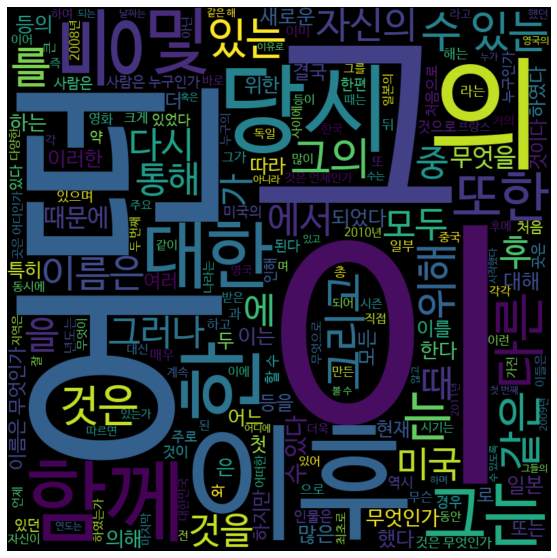

In [28]:
documents = []

for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)

        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)

documents[:10]
" ".join(documents[:10])

wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(" ".join(documents))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

> 그, 의, 어떤, 이, 이후, 함께 등의 글자가 빈도수가 높음을 확인할 수 있다.

# 3. Loading datasets for model learning

> 위 2장에서 모델 학습에 사용할 데이터를 생성 및 전처리 후, 파일로 저장했다.<br>
> 저장한 학습용 데이터셋을 읽은 후 메모리에 적재한다.

In [29]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

> json을 config 형태로 사용하기 위한 Class를 구현 후, 작동여부를 확인하기 위해 임의의 값을 넣어 확인한다.

In [30]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)
        
args = Config({'max_seq_length': 384, 'max_query_length': 64,})
args

{'max_seq_length': 384, 'max_query_length': 64}

> 생성한 데이터셋 파일을 메모리에 로딩하는 사용자 정의 함수를 구현한다.

In [31]:
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

> 생성한 데이터셋 파일을 메모리에 적재하고, 각 데이터의 차원을 확인한다

In [32]:
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

# 4. BERT model design

> BERT 모델은 Self-Attention 으로 이루어진 Encoder-Decoder 구조를 가진 Transformer모델과 흡사하지만 Transformer Encoder 구조만을 활용하는 모델이다.
> 

## 4.1 Util Functions

> BERT 모델을 구현함에 있어 편의성을 위한 유틸성 사용자 정의 함수들을 구현한다

In [33]:
# pad mask 계산하는 함수
def get_pad_mask(tokens, i_pad=0):
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    
    return mask


# ahead mask 계산하는 함수
def get_ahead_mask(tokens, i_pad=0):
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    
    return mask


# gelu activation 함수
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


# parameter initializer 생성 함수
def kernel_initializer(stddev=0.02):
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


# bias initializer 생성 함수
def bias_initializer():
    return tf.zeros_initializer

## 4.2 Weighed shared embedding class

> BERT의 모델에서 가중치를 공유하도록하는 임베딩 레이어 클래스를 구현한다.

In [34]:
class SharedEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="weight_shared_embedding"):
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        if mode == "embedding":
            return self._embedding(inputs)
        elif mode == "linear":
            return self._linear(inputs)
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        
        return embed

    def _linear(self, inputs):
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])
        
        return outputs

## 4.3 Positional embedding class

> Transformer에서 사용되던 position embedding과 동일한 기능을 수행하는 임베딩 레이어 클래스를 구현한다.

In [35]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="position_embedding"):
        super().__init__(name=name)
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        
        return embed

## 4.4 Scale dot product attention class

> Transformer에서 사용되던 Scale dot product attention과 동일한 기능을 수행하는 어텐션 클래스를 구현한다.

In [36]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, name="scale_dot_product_attention"):
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        
        return attn_out

## 4.5 Multi head attention class

> Transformer에서 사용되던 Multi head attention과 동일한 기능을 수행하는 어텐션 클래스를 구현한다.

In [39]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, config, name="multi_head_attention"):
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # step1. Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        
        # step2. Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        
        # step3. output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        # step1. reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # step2. Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)
        # step3. transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])
        attn_out = self.W_O(attn_out)

        return attn_out

## 4.6 Position wise feed forward class

>  Transformer에서 사용되던 feed forward network과 동일한 기능을 수행하는 Position wise feed forward 클래스를 구현한다.

In [40]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, config, name="feed_forward"):
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

## 4.7 Encoder layer class

> 위 4.1 ~ 4.6 장에서 구현한 클래스를 활용하여 BERT 모델의 인코더 레이어 클래스를 구현한다.

In [41]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, config, name="encoder_layer"):
        super().__init__(name=name)
        
        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))
        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

## 4.8 BERT model class

> 4.1~ 4.7장의 클래스를 활용하여 BERT 모델을 구현하는 클래스를 구현한다.

In [42]:
class BERT(tf.keras.layers.Layer):
    def __init__(self, config, name="bert"):
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]
        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)
        enc_embed = self.get_embedding(enc_tokens, segments)
        enc_out = self.dropout(enc_embed)
        
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        
        return embed

## 4.9 BERT4KorQuAD model class

> BERT 레이어에 Fully Connected layer를 붙어 KorQuAD용으로 finetune하기 위한 모델 클래스를 구현한다

In [43]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

# 5. Train pretrained BERT4KorQuAD model

> 본 장에서는 위 4장에서 구현한 BERT4KorQuAD 모델을 훈련하는 과정을 기술한다

## 5.1 Setting model hyper parameter

> 설정 기능을 수행하는 Config 클래스에 모델의 크기를 설정하는 값을 입력하여 설정 객체를 생성한다.

In [44]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

> BERT 모델의 배치 사이즈를 32로 설정하고 각 훈련용 데이터셋과 검증용 데이터 셋의 배치 크기를 설정한다.

In [45]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

## 5.2 Make pretrained BERT4KorQuAD model

> 위에서 설정한 값을 입력값으로 사전 학습된 pretrained BERT4KorQuAD 모델 객체를 생성한뒤 메모리에 할당한다.

In [46]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    
    model(enc_tokens, segments) 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)
    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_36 (Dense)             multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


## 5.3 Create train and eval epoch function

### 5.3.1 Create train epoch function

In [47]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

### 5.3.2 Create eval epoch function

In [48]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

## 5.4 model train

In [49]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

start_loss_list1_tr = []
end_loss_list1_tr = []
start_acc_list1_tr = []
end_acc_list1_tr = []

start_loss_list1 = []
end_loss_list1 = []
start_acc_list1 = []
end_acc_list1 = []

best_acc = .0
patience = 0
for epoch in range(10):
    tr_start_loss,tr_end_loss,tr_start_acc,tr_end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    
    start_loss_list1_tr.append(tr_start_loss)
    end_loss_list1_tr.append(tr_end_loss) 
    start_acc_list1_tr.append(tr_start_acc)
    end_acc_list1_tr.append(tr_end_acc) 
    
    start_loss_list1.append(start_loss) 
    end_loss_list1.append(end_loss) 
    start_acc_list1.append(start_acc)
    end_acc_list1.append(end_acc) 
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.7162, 1.9734, acc: 0.5641, 0.5172
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.6338, 1.8599, acc: 0.5715, 0.5369
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.8905, 2.1073, acc: 0.5636, 0.5332


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 1.9597, 2.2273, acc: 0.5629, 0.5230


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 2.0444, 2.1609, acc: 0.5557, 0.5077


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 5 >> loss: 2.2259, 2.3925, acc: 0.5483, 0.4932


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 6 >> loss: 2.5721, 3.0020, acc: 0.5530, 0.5207
early stopping


# 6. Result

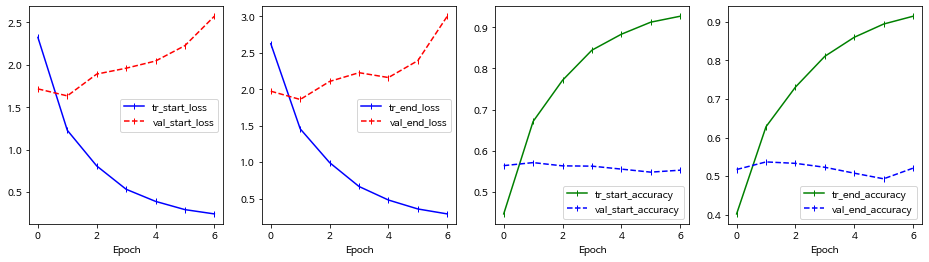

In [50]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.plot(start_loss_list1_tr, 'b|-', label='tr_start_loss')
plt.plot(start_loss_list1, 'r|--', label='val_start_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(end_loss_list1_tr, 'b|-', label='tr_end_loss')
plt.plot(end_loss_list1, 'r|--', label='val_end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(start_acc_list1_tr, 'g|-', label='tr_start_accuracy')
plt.plot(start_acc_list1, 'b|--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(end_acc_list1_tr, 'g|-', label='tr_end_accuracy')
plt.plot(end_acc_list1, 'b|--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

> start_loss은 train_loss은 안정적으로 감소하고, val_loss는 안정적으로 증가하는 모습을 보여준다.<br>
> end_loss는 train_loss은 안정적으로 감소하고, val_loss는 안정적으로 증가하는 모습을 보여준다.<br>
> start_accuracy는 train_accuracy은 안정적으로 증가하고, val_accuracy는 안정적으로 감소하는 모습을 보여준다.<br>
> end_accuracy는 train_accuracy은 안정적으로 증가하고, val_accuracy는 안정적으로 감소하는 모습을 보여준다.<br>

# 7. model Test

> finetune 학습이 완료된 pretrained BERT4KorQuAD model을 활용하여 실제 퀴즈 풀이 결과를 확인하는 사용자 정의 함수를 구현 후, 결과를 확인한다.

In [51]:
def do_predict(model, question, context):
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

> 10개의 질문에 대한 답변을 생성한다.

In [53]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 10 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

> 임의로 10개의 질문에 대한 예측을 진행했을때, 대부분의 질문에 올바른 답을 예측한 모습을 볼 수 있다.<br>
> 그러나 몇몇 질문에 대한 답을 맞추는것은 성공했으나, 자연스럽지않은 답을 예측한 모습을 볼 수 있다.<br>
> index 1의 질문에 대한 답변에 '-을'이라는 단어를 분리하지 못하는 모습을 보여주었다.<br>
> index 5, 6, 7, 9번의 경우에도 의 질문에 대한 답만 분리하지 못하고 지문의 내용 일부분을 그대로 가져오는 모습을 볼 수 있다.<br>

# 후기

> BERT 모델 훈련 후 결과를 확인했을때, 지문 데이터 속 수 많은 텍스트 중에서 정답의 위치를 높은 확률로 정확하게 찾아내는 모습이 인상적이였습니다.<br>
> 그와 함께, 이전에 했던 트랜스포머는 정답에 가까운 예측 값을 출력하도록 설계되었다면, BERT는 지문에서 질문에 대한 정답을 정확히 찾는데 설계되었다는 느낌을 받았습니다.<br>
> 그래서 BERT 모델은 사용자가 안전하고 편안한 서비스를 누릴 수 있도록 응대하는 안내원과 같이 질문에 대해 정확한 답변을 하는 챗봇 같은 서비스에 적합한 모델같다는 생각이 들었습니다.<br>
> 그렇기에, MLM(Masked Language Model)을 활용하여, 문학자가 찾기 못했던 숨겨진 의미를 찾는 고전 문서 번역, 문장 속에 숨겨진 단서 및 힌트 등을 찾는 문제에서 좋은 성과를 보여주지 않을까라는 생각도 드는 모델이였습니다.